In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances, pairwise_distances
import time


# Introduction

In [325]:
import load_dataset
X, y = load_dataset.main('news', 10000, 
                         n_features=30,
                         n_informative=12,
                         n_redundant=3,
                         n_repeated=1,
                         n_clusters_per_class=3)

print('Shape: ', X.shape)

Index([' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
       ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs',
       ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' gl

In [328]:
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



X_train, X_test, y_train, y_test = train_test_split(X, y)

#clf = RandomForestClassifier(100)
#clf = SVC(probability=True)
#clf = SGDClassifier('modified_huber')
clf = MLPClassifier(activation='identity')
#clf = BernoulliRBM()
'''logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)
clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
'''
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_p = clf.predict_proba(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))
print('auc ', roc_auc_score(y_test, y_pred))

#clf.feature_importances_

accuracy  0.6304
auc  0.613743466154


In [329]:
def pred(obs):
    if len(obs.shape) > 1 and obs.shape[1] > 1:
        return np.array([x[1] for x in clf.predict_proba(obs)])
    else:
        return clf.predict_proba(obs.reshape(1, -1))[0][1]

In [330]:
def distance_first_ennemy(observation, n=1):
    D = pairwise_distances(X, observation.reshape(1, -1), metric='euclidean')
    idxes = sorted(enumerate(D), key=lambda x:x[1])
    out = []
    dists = []
    k = 0
    while len(out) < n:
        i = idxes[k]
        if clf.predict(X[i[0]].reshape(1, -1)) != clf.predict(observation.reshape(1, -1)):
            out.append(X[i[0]])
            dists.append(pairwise_distances(X[i[0]].reshape(1, -1), observation.reshape(1, -1))[0][0])
        k += 1
    return out, dists

# Work

In [331]:
from scipy.stats import pearsonr, spearmanr

def interpretability_scores(obs_to_interprete, ennemy):
    eucl = pairwise_distances(obs_to_interprete.reshape(1,- 1), ennemy.reshape(1, -1))[0][0]
    var_non0 = sum((obs_to_interprete - ennemy) != 0)
    pearson = pearsonr(obs_to_interprete, ennemy)[0]
    #profil =
    return {'distance': eucl, 'nb_directions_move': var_non0, 'pearson':pearson}

# Benchmark

In [131]:
import exploration.uniform_growing_spheres
import imp
imp.reload(exploration.uniform_growing_spheres)

<module 'exploration.uniform_growing_spheres' from '/home/laugel/Documents/thesis/code/highgarden/highgarden/exploration/uniform_growing_spheres.py'>

In [332]:

def interpretability_metrics(X, prediction_function, interpretability_method, obs_to_interprete):
    t1 = time.time()
    nearest_ennemy = interpretability_method(X, prediction_function, obs_to_interprete)
    scores = interpretability_scores(obs_to_interprete, nearest_ennemy)
    scores['time'] = time.time() - t1
    return scores, nearest_ennemy


def benchmark_oneobs(X, prediction_function, modules, obs_to_interprete):
    df_benchmark = []
    ennemies = []
    index = []
    for mod_name, mod in modules.items():
        row, ennemy = interpretability_metrics(X, prediction_function, mod.main, obs_to_interprete)
        ennemies.append(ennemy)
        cols = list(row.keys())
        row = list(row.values())
        index.append(mod_name)
        df_benchmark.append(row)
    index_distance = cols.index('distance') 
    df_s = sorted(zip(df_benchmark, ennemies, index), key=lambda pair:pair[0][index_distance])
    df_benchmark, ennemies, index = [x[0] for x in df_s], [x[1] for x in df_s], [x[2] for x in df_s]
    ennemies = np.array(ennemies)
    df_benchmark = pd.DataFrame(df_benchmark, columns=cols, index=index)
    
    return df_benchmark, ennemies

def benchmark_several(X, prediction_function, modules_to_aggregate, number_observations):
    i = 0
    for i in range(number_observations):
        print('observation ', i)
        idx_test = np.random.randint(X_test.shape[0])
        obs_to_interprete = X_test[idx_test]
        benchmark, _ = benchmark_oneobs(X, prediction_function, modules_to_aggregate, obs_to_interprete)
        if i == 0:
            out = benchmark/float(number_observations)
        else:
            out += benchmark/float(number_observations)
    return out
    


In [333]:
import exploration.uniform_growing_spheres
import exploration.path_to_ennemies
import exploration.uniform_growing_spheres_featsel
import exploration.path_to_ennemies_featsel


modules_ = {'gs': exploration.uniform_growing_spheres,
            'gs_feat_sel': exploration.uniform_growing_spheres_featsel,
          'pte': exploration.path_to_ennemies,
          'pte_feat_sel': exploration.path_to_ennemies_featsel}  
          

modules2 = {'gs': exploration.uniform_growing_spheres,
            'gs_feat_sel': exploration.uniform_growing_spheres_featsel,
           'pte':exploration.path_to_ennemies,
           'pte_feat_sel': exploration.path_to_ennemies_featsel}

idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])
obs_to_interprete = X[idx]
fe, dfe = distance_first_ennemy(obs_to_interprete)
fe = fe[0]
dfe = dfe[0]

bench, ennemies = benchmark_oneobs(X, pred, modules_, obs_to_interprete)

#benchmark_dataset = benchmark_several(X, pred, modules2, 50)

print(pred(obs_to_interprete))
bench


zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
Final nb of iterations  2 Final radius (array([  3.34596038e-66]), array([  4.46128050e-66]))
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
zoom
Final nb of iterations  1 Final radius (array([  1.11532013e-62]), array([  2.23064025e-62]))
0.450570463129


,pearson,distance,nb_directions_move,time
gs_feat_sel,0.999723,0.057492,19,8.968751
gs,0.999411,0.084179,58,8.089228
pte_feat_sel,0.993912,0.293602,6,4.110901
pte,0.987499,0.426503,32,0.642371


# Results

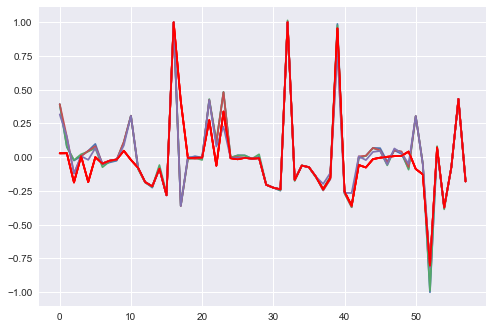

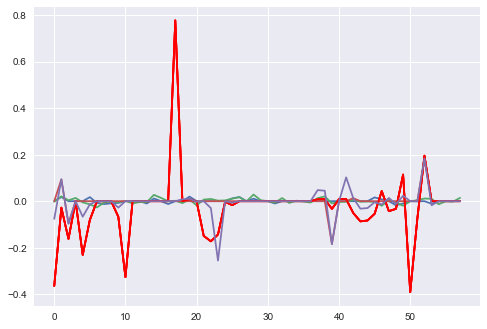

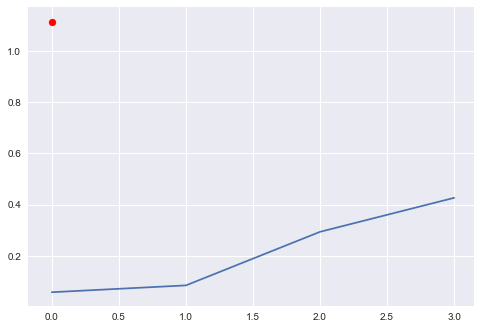

In [334]:
df_benchmark = bench
for e in range(df_benchmark.shape[0]):
    plt.plot(ennemies[e, :])
    plt.plot(fe, color='red')
#plt.plot(ennemies[6,:], color='black')
plt.show()


for e in range(df_benchmark.shape[0]):
    plt.plot(fe - obs_to_interprete, color='red')
    plt.plot(ennemies[e, :] - obs_to_interprete)
#plt.plot(ennemies[6, :] - obs_to_interprete, color='black')
plt.show()

             
plt.plot(df_benchmark['distance'].tolist())
plt.scatter(0, dfe, color='red')
plt.show()

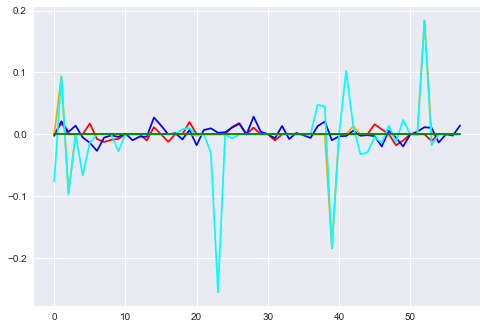

In [335]:
plt.plot(ennemies[0] - obs_to_interprete, color='red')
plt.plot(ennemies[1]- obs_to_interprete, color='blue')
plt.plot(ennemies[2]- obs_to_interprete, color='orange')
plt.plot(ennemies[3]- obs_to_interprete, color='cyan')
plt.plot(obs_to_interprete- obs_to_interprete, color='green')
plt.show()

In [336]:
variable_names = [' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
       ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ' abs_title_sentiment_polarity']


'''['Round', 'FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'TPW.1', 'FSP.2', 'FSW.2', 'SSP.2',
       'SSW.2', 'ACE.2', 'DBF.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'TPW.2']
'''

print(pred(obs_to_interprete), pred(ennemies[0]))
list(zip(variable_names, ennemies[0] - obs_to_interprete))


0.450570463129 0.500345964163


[(' n_tokens_title', 0.0),
 (' n_tokens_content', 0.017882455827599696),
 (' n_unique_tokens', 0.0),
 (' n_non_stop_words', 0.0),
 (' n_non_stop_unique_tokens', 0.0),
 (' num_hrefs', 0.017415768566147044),
 (' num_self_hrefs', -0.0076891923189509256),
 (' num_imgs', -0.01249578992365509),
 (' num_videos', -0.0091096537669431155),
 (' average_token_length', -0.0076092924256533218),
 (' num_keywords', 0.0),
 (' data_channel_is_lifestyle', 0.0),
 (' data_channel_is_entertainment', 0.0),
 (' data_channel_is_bus', -0.010096784454366514),
 (' data_channel_is_socmed', 0.011437927190767472),
 (' data_channel_is_tech', 0.0),
 (' data_channel_is_world', -0.012296582978898685),
 (' kw_min_min', 0.0),
 (' kw_max_min', 0.0),
 (' kw_avg_min', 0.01976282362838204),
 (' kw_min_max', 0.0),
 (' kw_max_max', 0.0),
 (' kw_avg_max', 0.0),
 (' kw_min_avg', 0.0),
 (' kw_max_avg', 0.0),
 (' kw_avg_avg', 0.011992720205566078),
 (' self_reference_min_shares', 0.018075684448060788),
 (' self_reference_max_shares

In [337]:
def distance(obs1, obs2):
    return pairwise_distances(obs1.reshape(1,- 1), obs2.reshape(1, -1))[0][0]
def generate_between(obs1, obs2, n=10000):
    news = []
    for i in range(n):
        a = random.random() * 1
        new = a * obs2 + (1 - a)*obs1
        news.append(new)
    return news
def pred_segment(obs1, obs2):
    preds = [int(pred(x)>= 0.5) for x in generate_between(obs1, obs2)]
    return sum(preds)/float(len(preds))


pred_segment(ennemies[0], ennemies[2])

1.0

# New Algorithm

In [340]:
def first_ennemies(X, observation, prediction_function, n_ennemies=1):
    D = pairwise_distances(X, observation.reshape(1, -1), metric='euclidean', n_jobs=-1)
    idxes = sorted(enumerate(D), key=lambda x:x[1])
    enn = []
    k = 0
    while len(enn) < n_ennemies:
        i = idxes[k]
        if (prediction_function(X[i[0]]) >= 0.5) != (prediction_function(observation) >=0.5):
            enn.append(X[i[0]])
        k += 1
    return enn

fenn = first_ennemies(X, obs_to_interprete, pred, 5)


def quel_sens(obs_to_interprete, ennemieslist, v):
    sgn = [0, 0, 0]
    for e in ennemieslist:
        a = e[v] - obs_to_interprete[v]
        if a < 0:
            sgn[0] += 1
        elif a == 0:
            sgn[1] += 1
        else:
            sgn[2] += 1
    return sorted(enumerate(sgn), key=lambda x: -x[1])[0][0]

sens = []
for v in range(X.shape[1]):
    sens.append(quel_sens(obs_to_interprete, fenn, v) -1) #rescale en -1 0 1
#sens est une liste des signes ou il faut generer


def generate_inside_space(center, d, segment, n):
    out = np.zeros((n, 1))
    for v in range(d):
        if sens[v] != 0:
            coord = (center[v] + np.random.uniform(*segment, n) * sens[v]).reshape(n, 1)
        else:
            coord = np.array([center[v]] * n).reshape(n, 1)
        out = np.concatenate((out, coord), axis=1)
    return out[:, 1:]


def generate_layer_with_pred2(prediction_function, center, d, n, segment):
    out = []
    a_ = generate_inside_space(center, d, segment, n) #n observations
    pred_ = np.array([int(x>= 0.5) for x in prediction_function(a_)]) #predictions of n observations
    a_ = np.concatenate((a_, pred_.reshape(n, 1)), axis=1)
    return a_ 

def seek_ennemies2(X, prediction_function, obs_to_interprete, n_layer, step, enough_ennemies):
    PRED_CLASS = int(prediction_function(obs_to_interprete)>=0.5)
    ennemies = []
    fe, dfe = distance_first_ennemy(obs_to_interprete)
    fe = fe[0]
    dfe = dfe[0]
    step = dfe * step
    a0, a1 = 0, step
    i = 0
    layer_ = generate_layer_with_pred2(prediction_function, obs_to_interprete, X.shape[1], n=n_layer, segment=(a0, a1))
    layer_enn = [x for x in layer_ if x[-1] == 1-PRED_CLASS]
    while len(layer_enn) > 0:
        step = step / 100.0
        a1 = step
        layer_ = generate_layer_with_pred2(prediction_function, obs_to_interprete, X.shape[1], n=n_layer, segment=(a0, a1))
        layer_enn = [x for x in layer_ if x[-1] == 1-PRED_CLASS]
        print('zoom')  
    else:
        while len(ennemies) < 1:
            layer_ = generate_layer_with_pred2(prediction_function, obs_to_interprete, X.shape[1], n=n_layer, segment=(a0, a1))
            layer_enn = [x for x in layer_ if x[-1] == 1-PRED_CLASS]
            #import pdb;pdb.set_trace()
            ennemies.extend(layer_enn)
            i += 1
            print(i)
            a0 += step
            print(a0)
            a1 += step
    print('Final nb of iterations ', i, 'Final radius', (a0,a1))
    return ennemies

def l2(obs1, obs2):
    return pairwise_distances(obs1.reshape(1, -1), obs2.reshape(1, -1))[0][0]

def growing_sphere_explanation2(X, prediction_function, obs_to_interprete, n_layer=10000, step=1/2.0, enough_ennemies=1, moving_cost=l2):
    ennemies = seek_ennemies2(X, prediction_function, obs_to_interprete, n_layer, step, enough_ennemies)
    nearest_ennemy = sorted(ennemies, key=lambda x: moving_cost(obs_to_interprete, x[:-1]))[0][:-1]
    return nearest_ennemy
print('go')
e1= interpretability_metrics(X, pred, growing_sphere_explanation2, obs_to_interprete)
e2 =interpretability_metrics(X, pred, exploration.uniform_growing_spheres.main, obs_to_interprete)
e3 =interpretability_metrics(X, pred, exploration.path_to_ennemies.main, obs_to_interprete)

go
zoom
1
0.00557660063019
2
0.0111532012604
3
0.0167298018906
4
0.0223064025207
5
0.0278830031509
6
0.0334596037811
7
0.0390362044113
8
0.0446128050415
9
0.0501894056717
10
0.0557660063019
11
0.061342606932
12
0.0669192075622
13
0.0724958081924
14
0.0780724088226
15
0.0836490094528
16
0.089225610083
17
0.0948022107131
18
0.100378811343
19
0.105955411974
20
0.111532012604
21
0.117108613234
22
0.122685213864
23
0.128261814494
24
0.133838415124
25
0.139415015755
26
0.144991616385
27
0.150568217015
28
0.156144817645
29
0.161721418275
30
0.167298018906
31
0.172874619536
32
0.178451220166
33
0.184027820796
34
0.189604421426
35
0.195181022056
36
0.200757622687
37
0.206334223317
38
0.211910823947
39
0.217487424577
40
0.223064025207
41
0.228640625838
42
0.234217226468
43
0.239793827098
44
0.245370427728
45
0.250947028358
46
0.256523628989
47
0.262100229619
48
0.267676830249
49
0.273253430879
50
0.278830031509
51
0.284406632139
52
0.28998323277
53
0.2955598334
54
0.30113643403
55
0.30671303466


KeyboardInterrupt: 

In [324]:
'''
sens = directions nouvel algo - obs_to_interprete
sens2 = directions gs
sens3 = direction pte
autres = directions vrais ennemis
'''

e2
sens2 = []
for v in range(X.shape[1]):
    sens2.append(quel_sens(obs_to_interprete, [e2[1]], v) -1)
sens3 = []
for v in range(X.shape[1]):
    sens3.append(quel_sens(obs_to_interprete, [e3[1]], v) -1)

enn = distance_first_ennemy(obs_to_interprete, 5)[0]
    
print(sum(np.array(sens3) - np.array(sens)==0), sum(np.array(sens) - np.array(sens2) == 0))
for e in enn:
    sense = []
    for v in range(X.shape[1]):
        sense.append(quel_sens(obs_to_interprete, [e], v) -1)
    print(sum(np.array(sense) - np.array(sens)==0))

25 18
25
26
23
27
24


# Other: Tuning

In [ ]:

'''
TUNING

ATTENTION SEPARER DES PLOTS D EN DESSOUS
'''
NN = 20
dists, times, pars = [], [], []
params_nlayer = [100, 500, 1000, 2000, 5000, 10000, 50000, 100000]
params_nennemies=[1, 3, 5, 10, 20, 50] 
for nlayer in params_nlayer:
    for nennemies in params_nennemies:
        dist, t = 0.0, 0.0
        params = (nlayer, nennemies)
        print(params)
        for i in range(NN):
            ts = time.time()
            ne = interpretability_scores(obs_to_interprete, exploration.path_to_ennemies.main(X, pred, obs_to_interprete, n_layer=nlayer, n_ennemies=nennemies))
            dist += ne['distance']
            t += ts - time.time()
        times.append(t/float(NN))
        dists.append(dist/float(NN))
        pars.append(params)




'''
TUNING PLOTS: A SEPARER
'''

#np.transpose(np.array((pars, dists, times)))

arr = np.concatenate((np.array(pars), np.array(dists).reshape(len(dists), 1), np.array(times).reshape(len(dists), 1)), axis=1)
#nb_layer, step, mean_dist, mean_time


NLA = 2000
STP = 1

plt.plot([x[0] for x in arr if x[1]==STP], [x[2] for x in arr if x[1]==STP], color='blue')
plt.ylabel('Average distance obs-ennemy')
plt.xlabel('Number of observations per layer')
plt.xticks([x[0] for x in arr if x[1]==STP], [str(x[0]) for x in arr if x[1]==STP])
plt.show()

plt.plot([x[0] for x in arr if x[1]==STP], [abs(x[3]) for x in arr if x[1]==STP], color='red')
plt.ylabel('Average computation time(s)')
plt.xlabel('Number of observations per layer')
plt.xticks([x[0] for x in arr if x[1]==STP], [str(x[0]) for x in arr if x[1]==STP])
plt.show()


# Other: Convexity tests

In [ ]:
score = 0
for i in range(100):
    print('observation ', i)
    idx_test = np.random.randint(X_test.shape[0])
    obs_to_interprete = X_test[idx_test]
    pte = exploration.path_to_ennemies.main(X, pred, obs_to_interprete)
    gs = exploration.uniform_growing_spheres.main(X, pred, obs_to_interprete)
    score += ((pred_segment(pte, gs) - 0.5)**2)*4
score/100
